# X-SELL WORKSHOP  

14th Septmeber, 2023

##### Imports

In [1]:
from IPython.display import Image
import sys
import os
import subprocess

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext ,Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from datetime import date
from dateutil.relativedelta import relativedelta
from pyspark.sql.window import Window
import numpy as np
import pandas as pd

import datetime as dt

from datetime import timedelta

from pyspark.sql.functions import *
import random
from datetime import datetime, timedelta
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, FloatType

In [9]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("spark_session") \
    .config("spark.sql.catalogImplementation", "hive") \
    .config("spark.sql.caseSensitive", "false") \
    .config("hive.exec.dynamic.partition", "true") \
    .config("hive.exec.dynamic.partition.mode", "nonstrict") \
    .config("spark.sql.htl.check", "false") \
    .config("spark.sql.legacy.allowCreatingManagedTableUsingNonmptyLocation", "true") \
    .enableHiveSupport() \
    .master("local[*]") \
    .getOrCreate()

## 1. Context

### 1.1. Use case description

<span style='color: #67738C; font-weight: bold;'>Client:</span>
<span style='color: #686868;'>one of the largest bank in a region</span>

<span style='color: #67738C; font-weight: bold;'>Sales mechanics 1:</span>
<span style='color: #686868;'>the company mainly uses such sales channels like Telesales, Digital channels (SMS, WhatsApp), branches etc. For those channels there is a need to focus on:
    
<span style='color: #686868;'> - What <span style='color: #686868;font-weight: bold;'> clients </span></span>
<span style='color: #686868;'>should we choose for every product to sell them and maximise the propensity of a customer to buy it and our profit (or any other financial metrics)?
<span style='color: #67738C;'> (defined further as <span style='color: #67738C; font-weight: bold;'> outbound models)
    
<span style='color: #67738C; font-weight: bold;'>Sales mechanics 2:</span>
<span style='color: #686868;'> a client communicates directly to a sales manager in a branch or by an online consultation. For those channels there is a need to focus on:
    
<span style='color: #686868;'> - What <span style='color: #686868;font-weight: bold;'> products <span style='color: #686868;'> </span></span> should we offer for this particular client to maximise the propensity of a customer to buy it and our profit (or any other financial metrics)?
<span style='color: #67738C;'> (defined further as <span style='color: #67738C; font-weight: bold;'> outbound models)

</span>

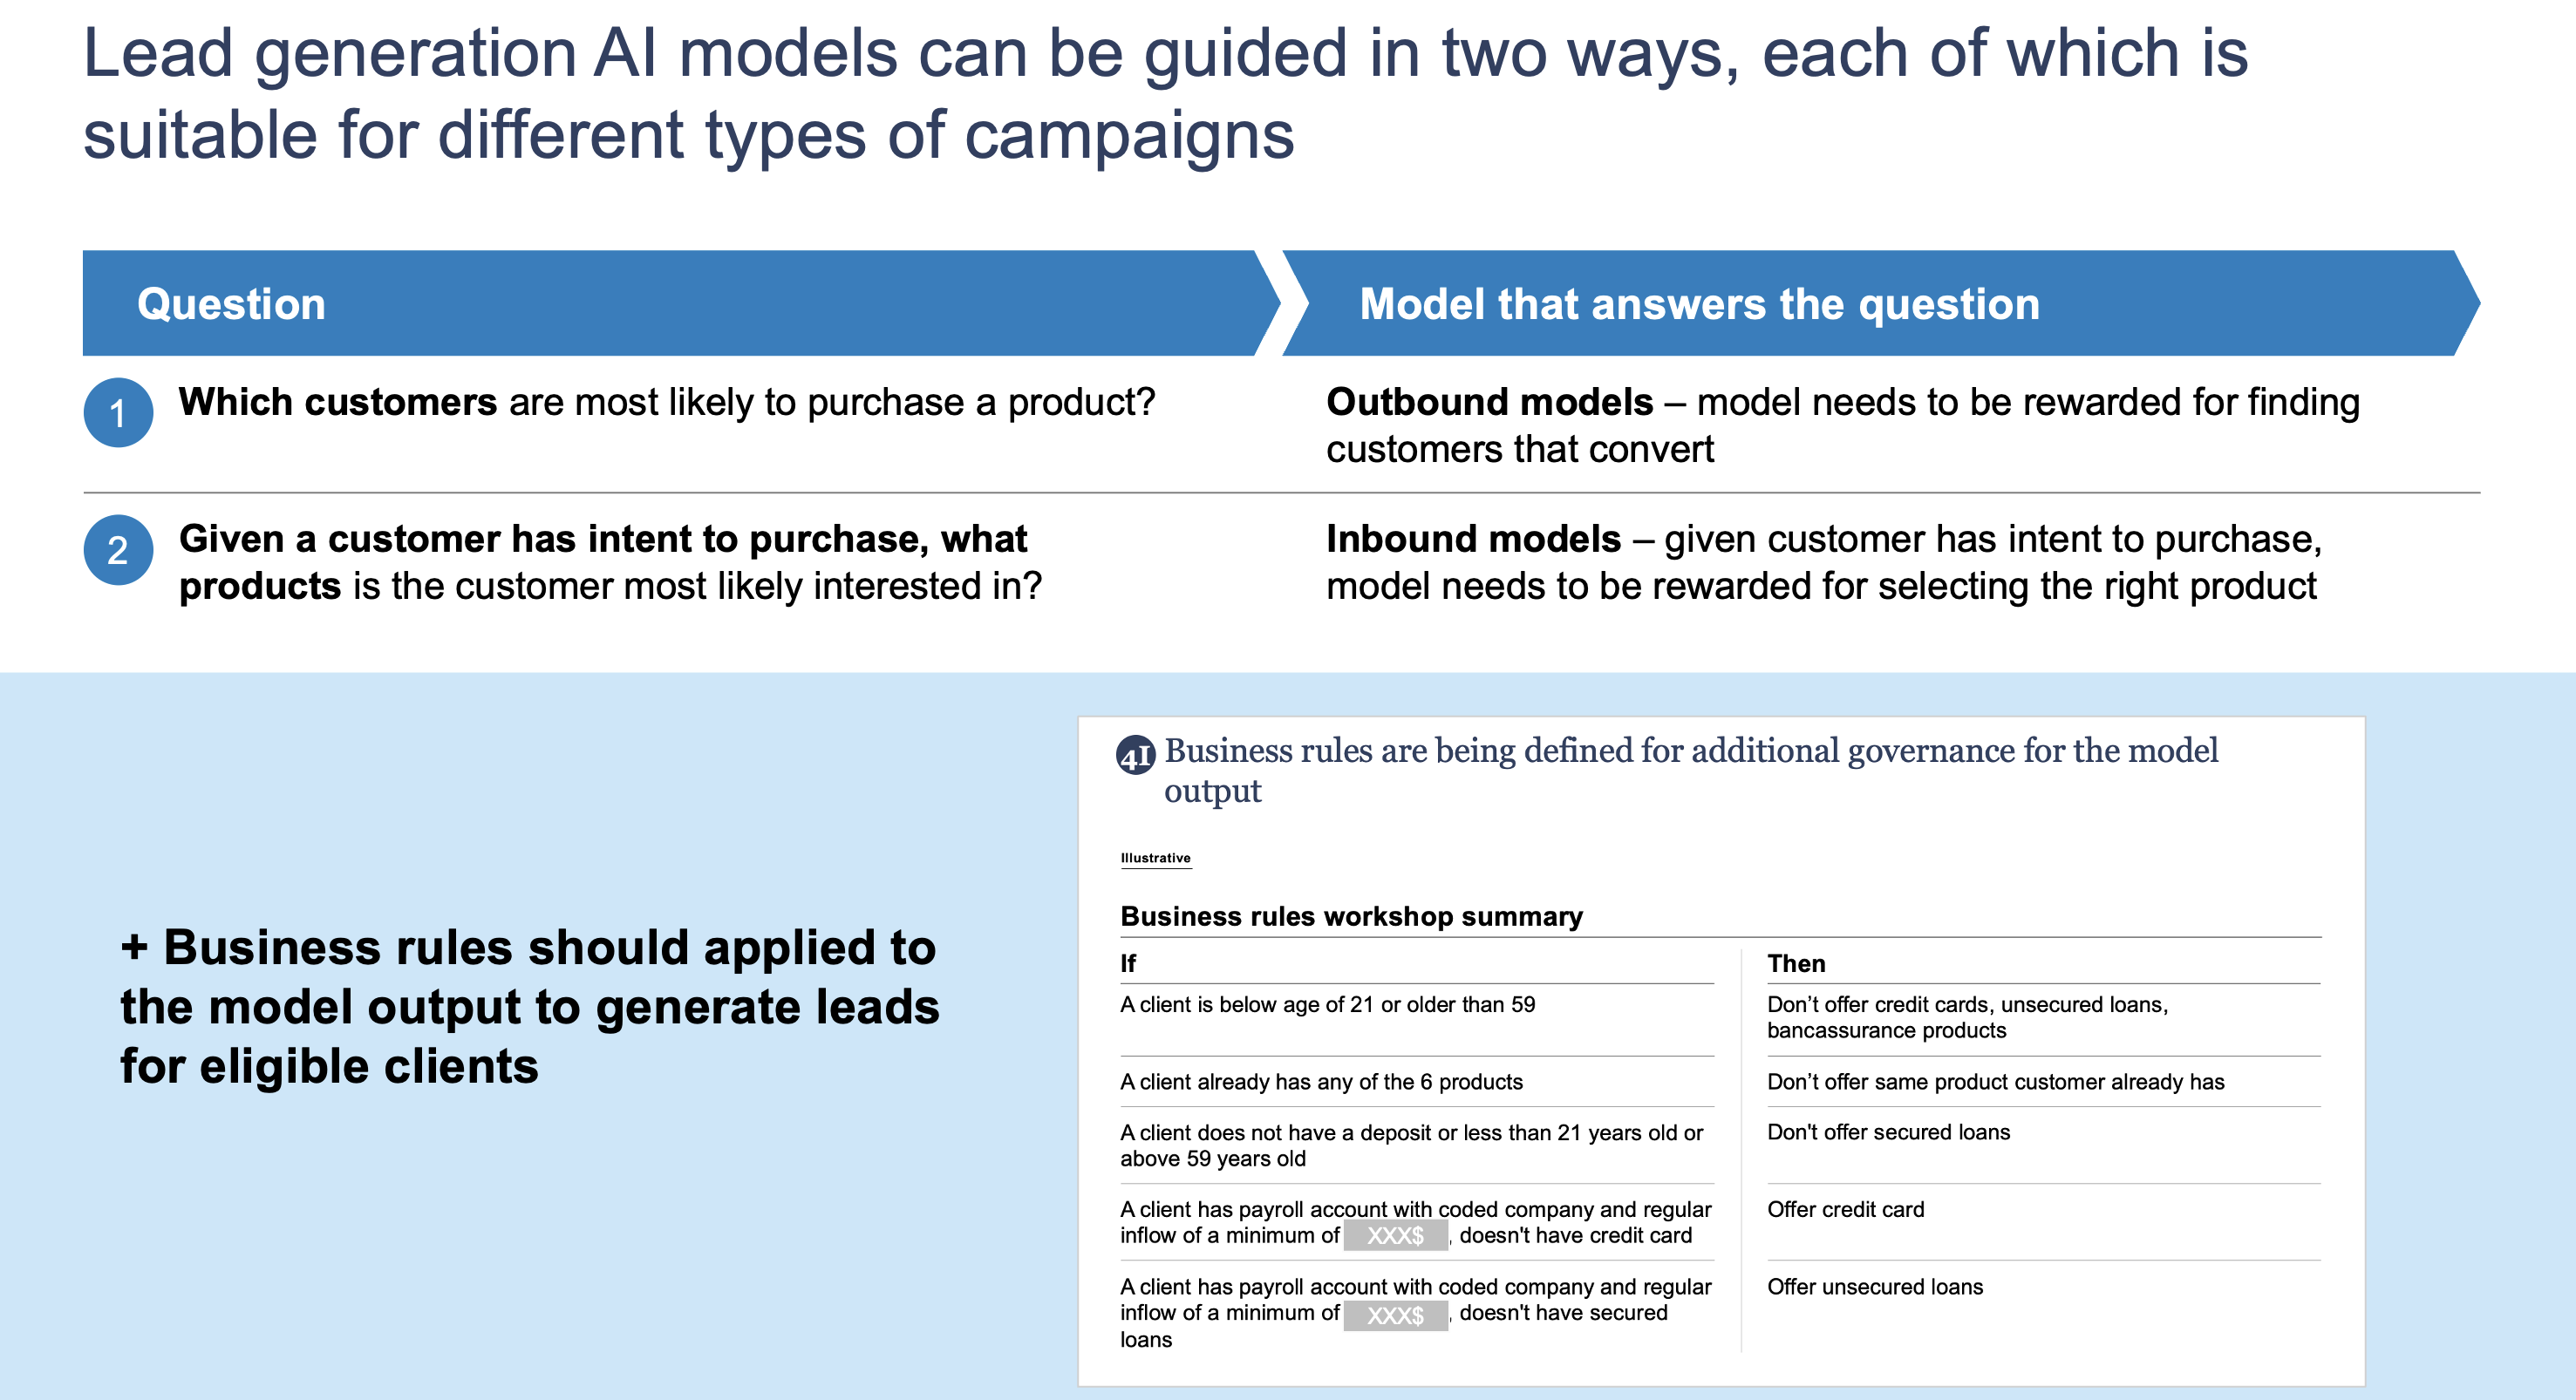

In [134]:
Image(filename='pictures/models.png')

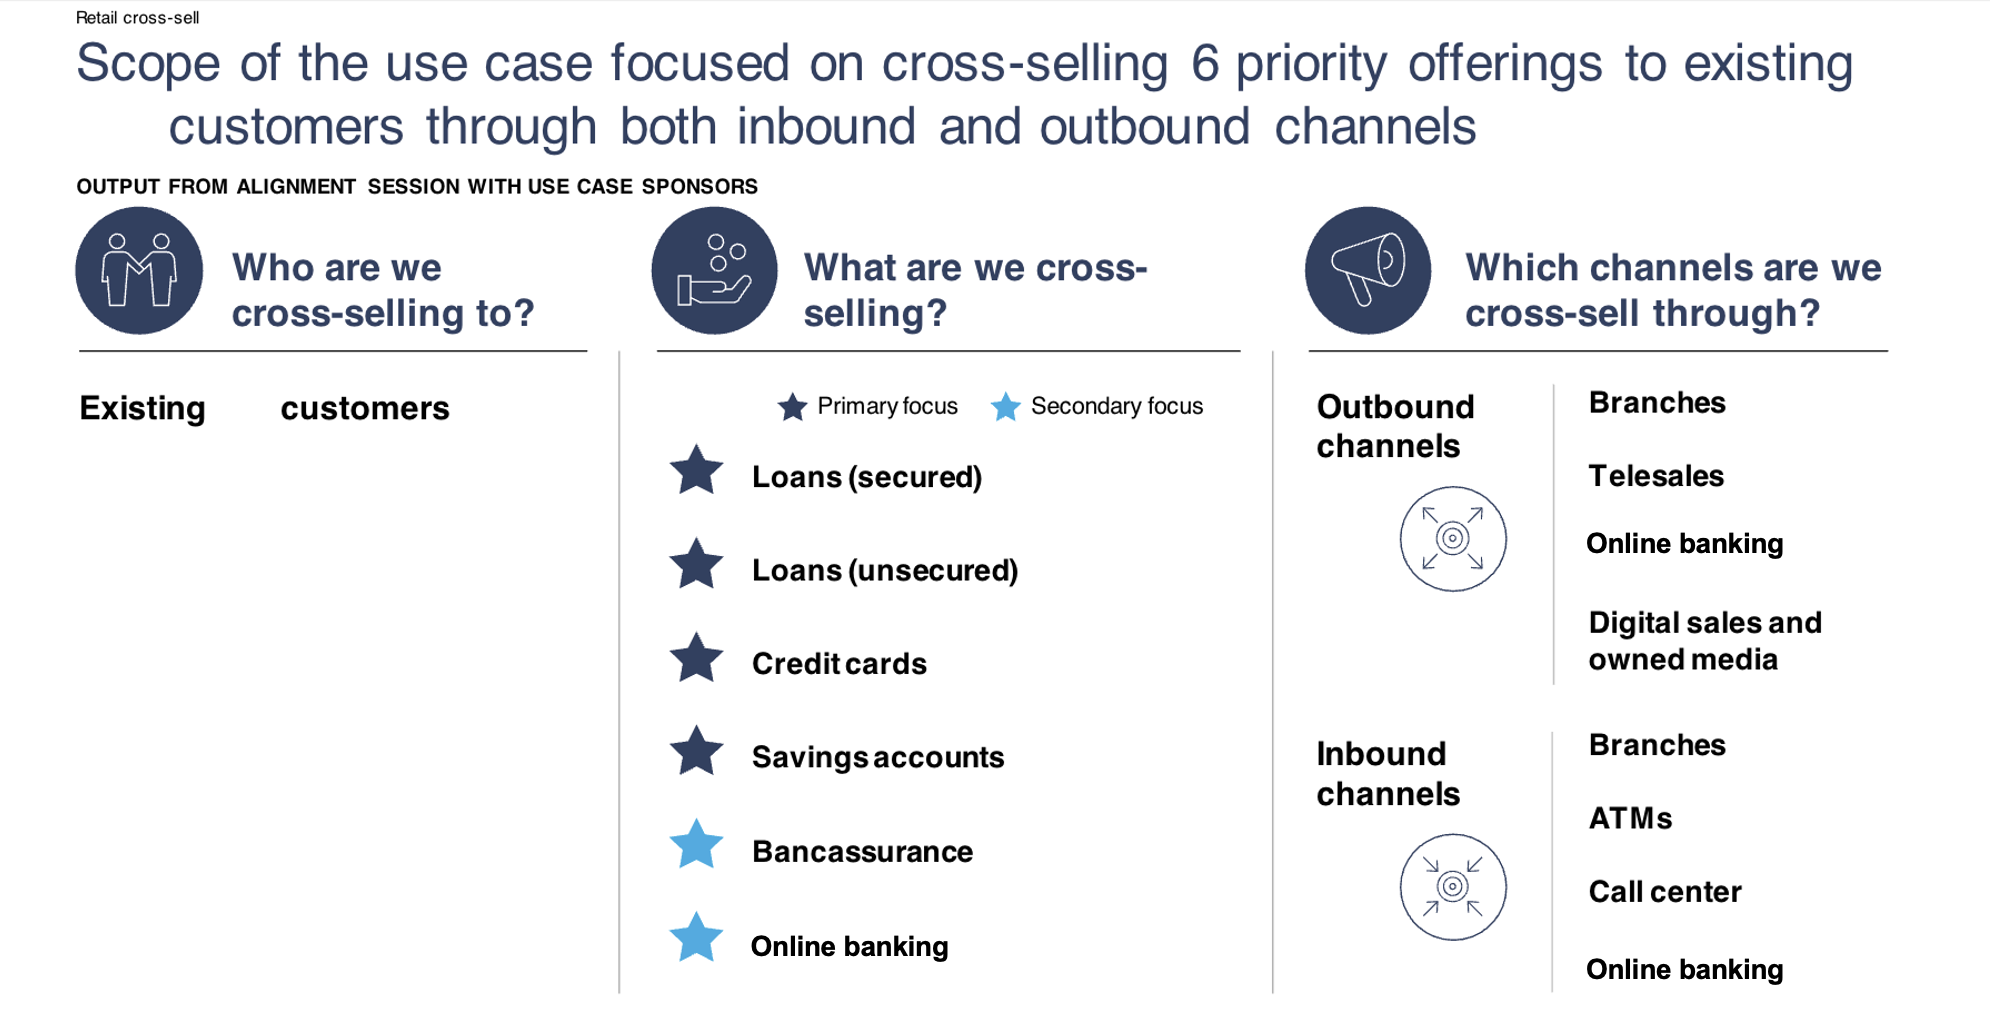

In [135]:
Image(filename='pictures/scope.png')

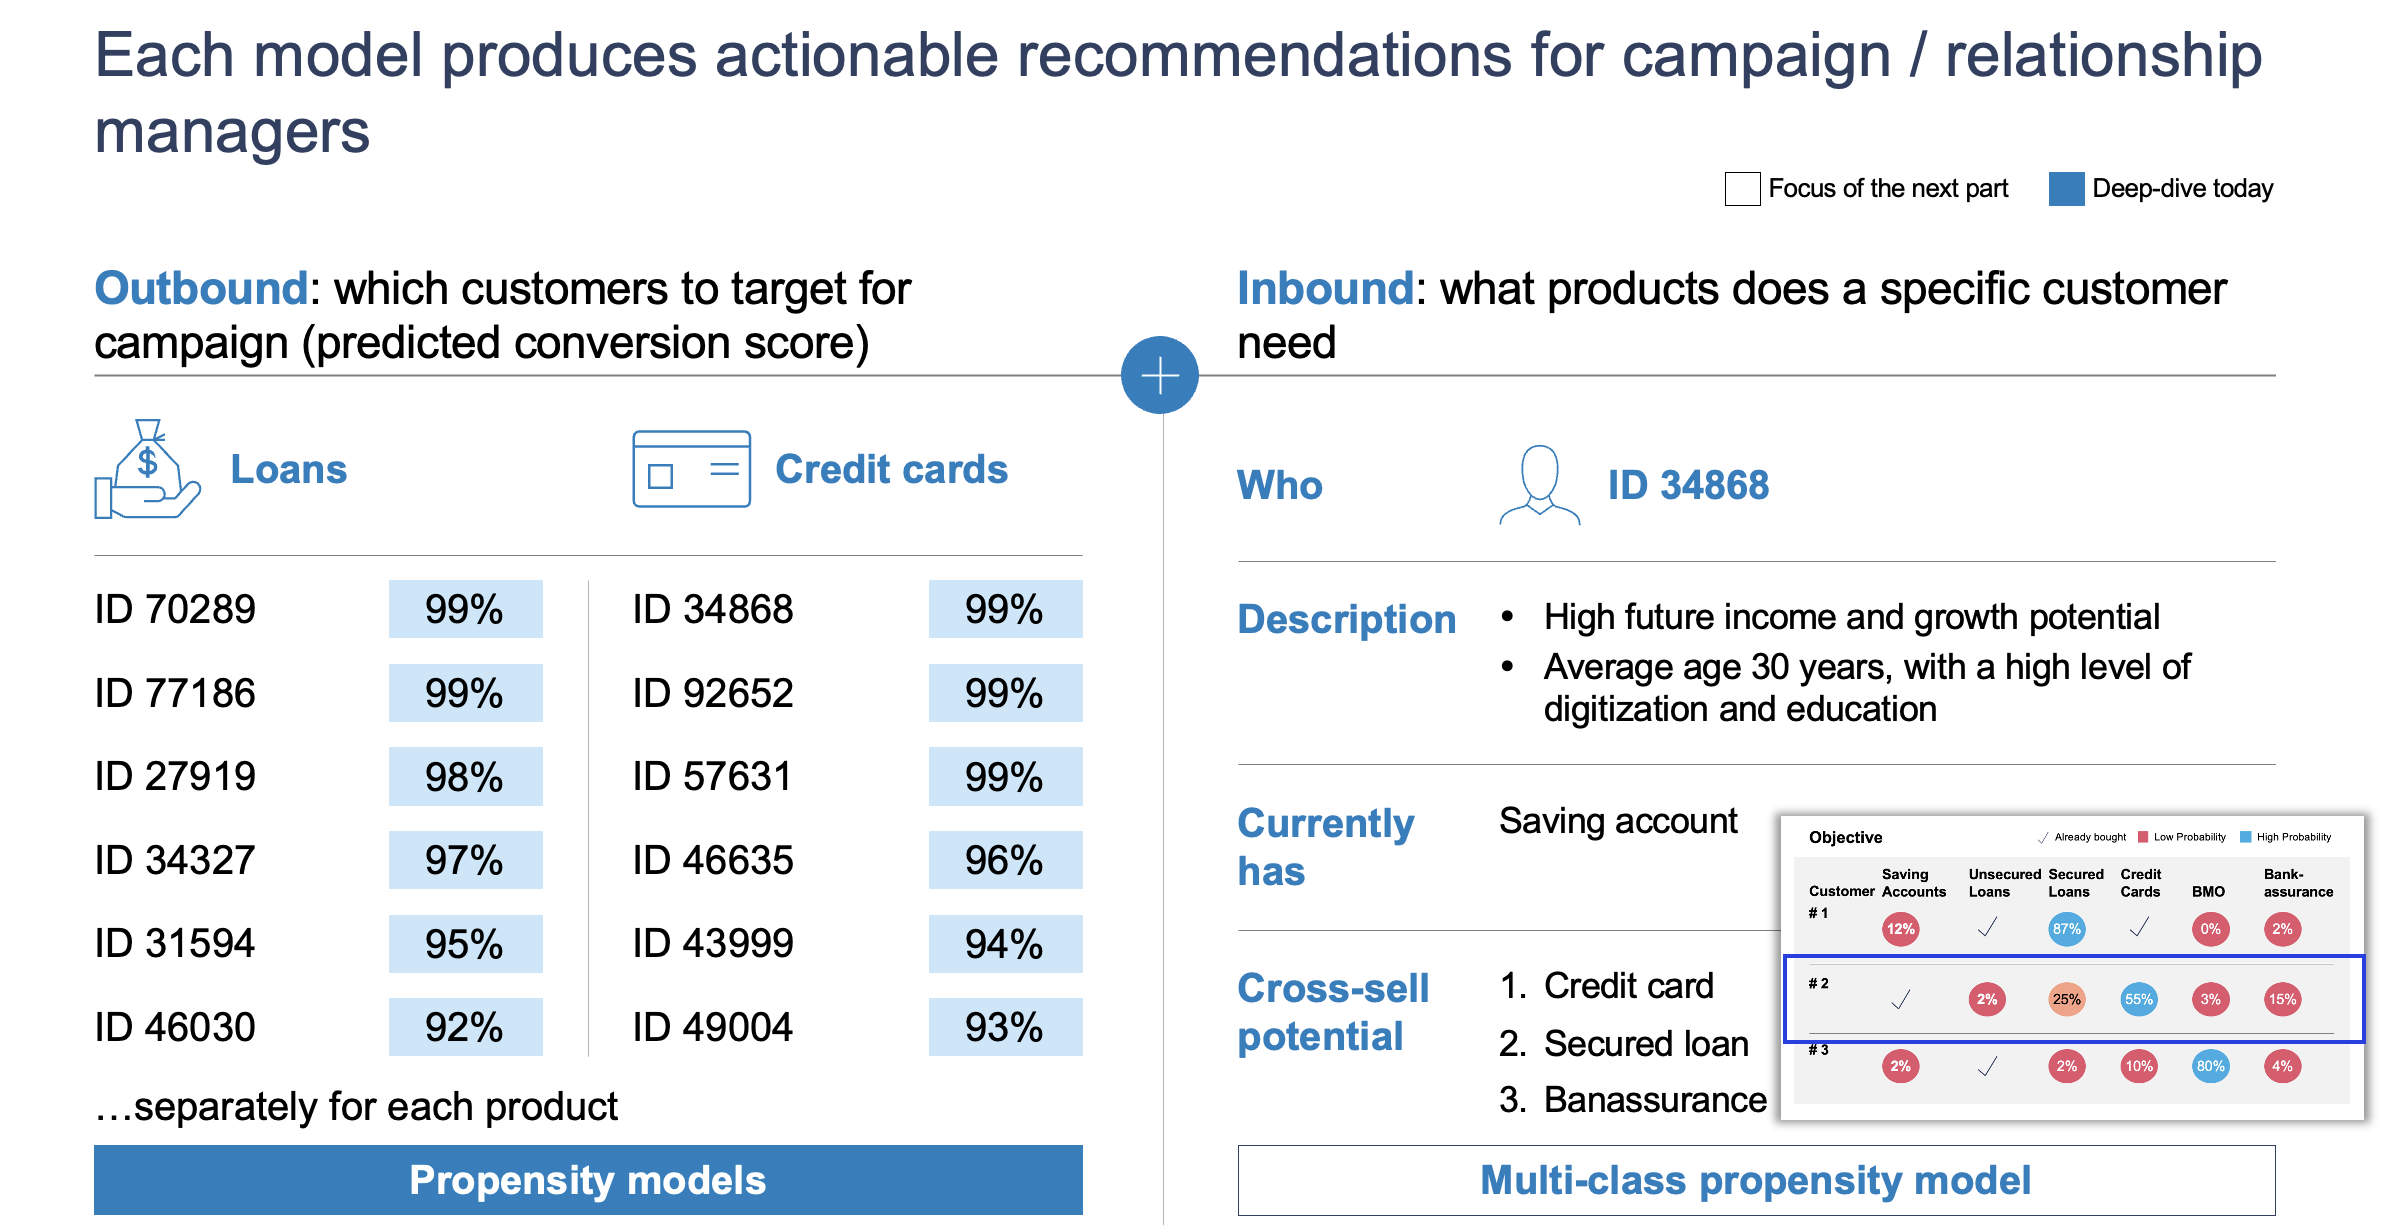

In [136]:
Image(filename='pictures/models_details.png')

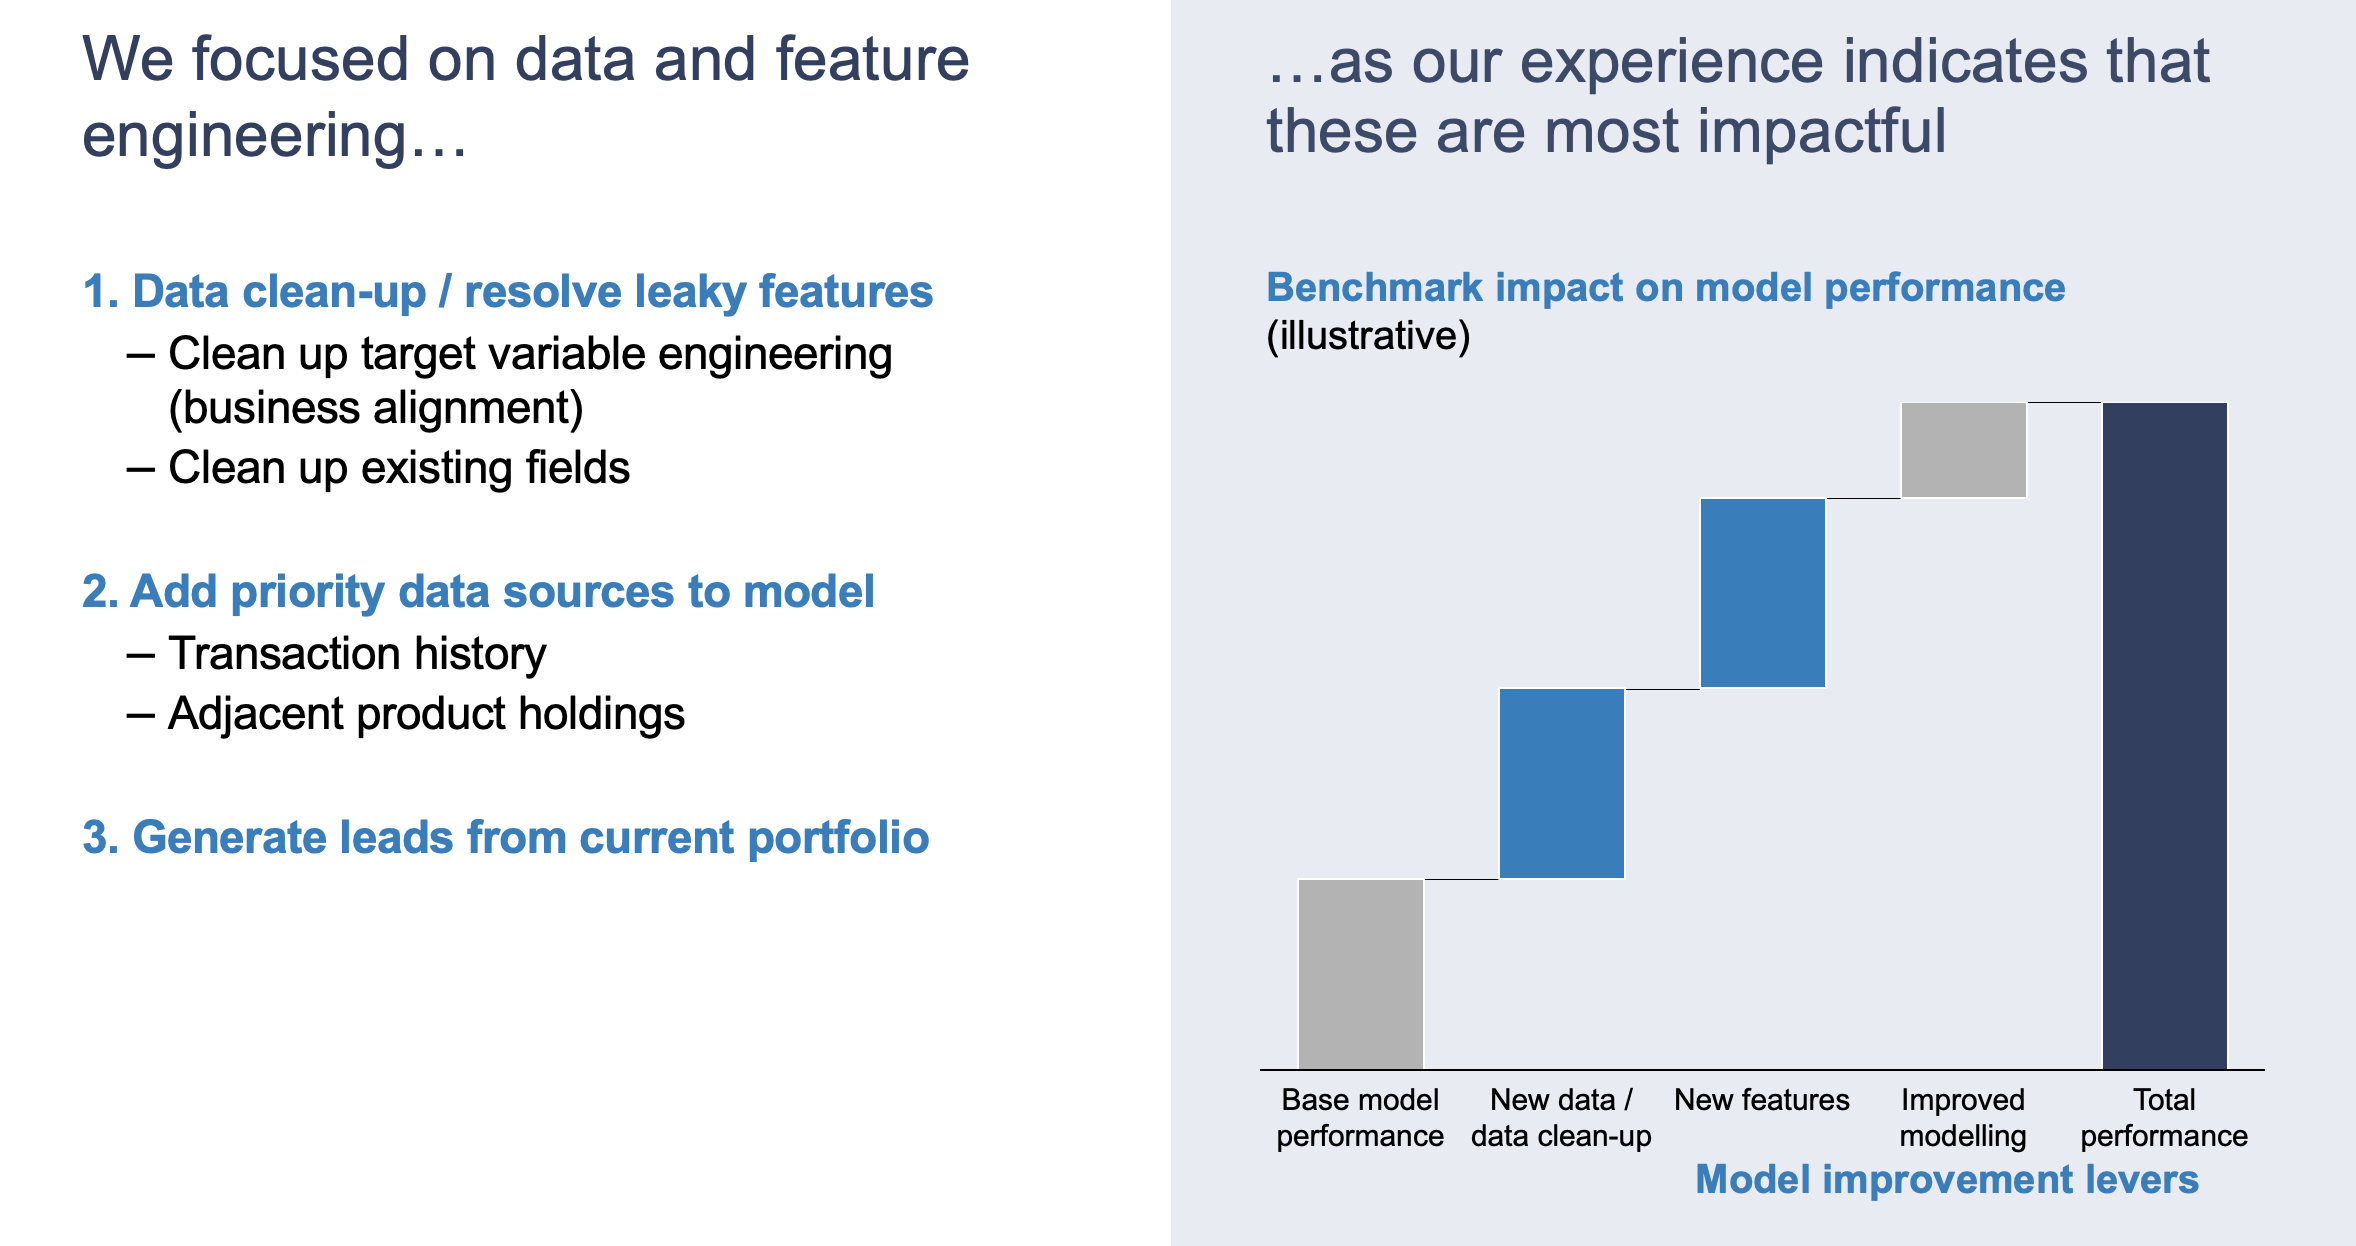

In [137]:
Image(filename='pictures/process.png')

### 1.2. Challenges

| N | Description                                                                                                                                                                                                | Eliminanion                                                                                                                                               |
|---|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1 | Structure: Raw data is poorly organized                                                                                                                                                                    | Step-by-step structure of every raw data source processing; configuration file.                                                                           |
| 2 | Data Quality: dozens of data sources + lack of its knowledge + a lot of quality issues                                                                                                                     | Checks added at every stage of the process: N of missing values, all possible aggregated checks & continuous control that all final values are correct.   |
| 3 | Technical restrictions: code in Zeppelin notebooks on local PC's only, two environments - %python and %pyspark, where not all libraries ara availble inside. %python contain python 2.X version installed. | Specifics of some code lines.                                                                                                                             |
| 4 | Low memory capacity ~3gb per user with millions of data for processing | Saving preliminary stages, code optimization.                                                                                                                             |
| 5 | No version control available | Config file                                                                                                                           |

## 2. X-sell approach

### Description

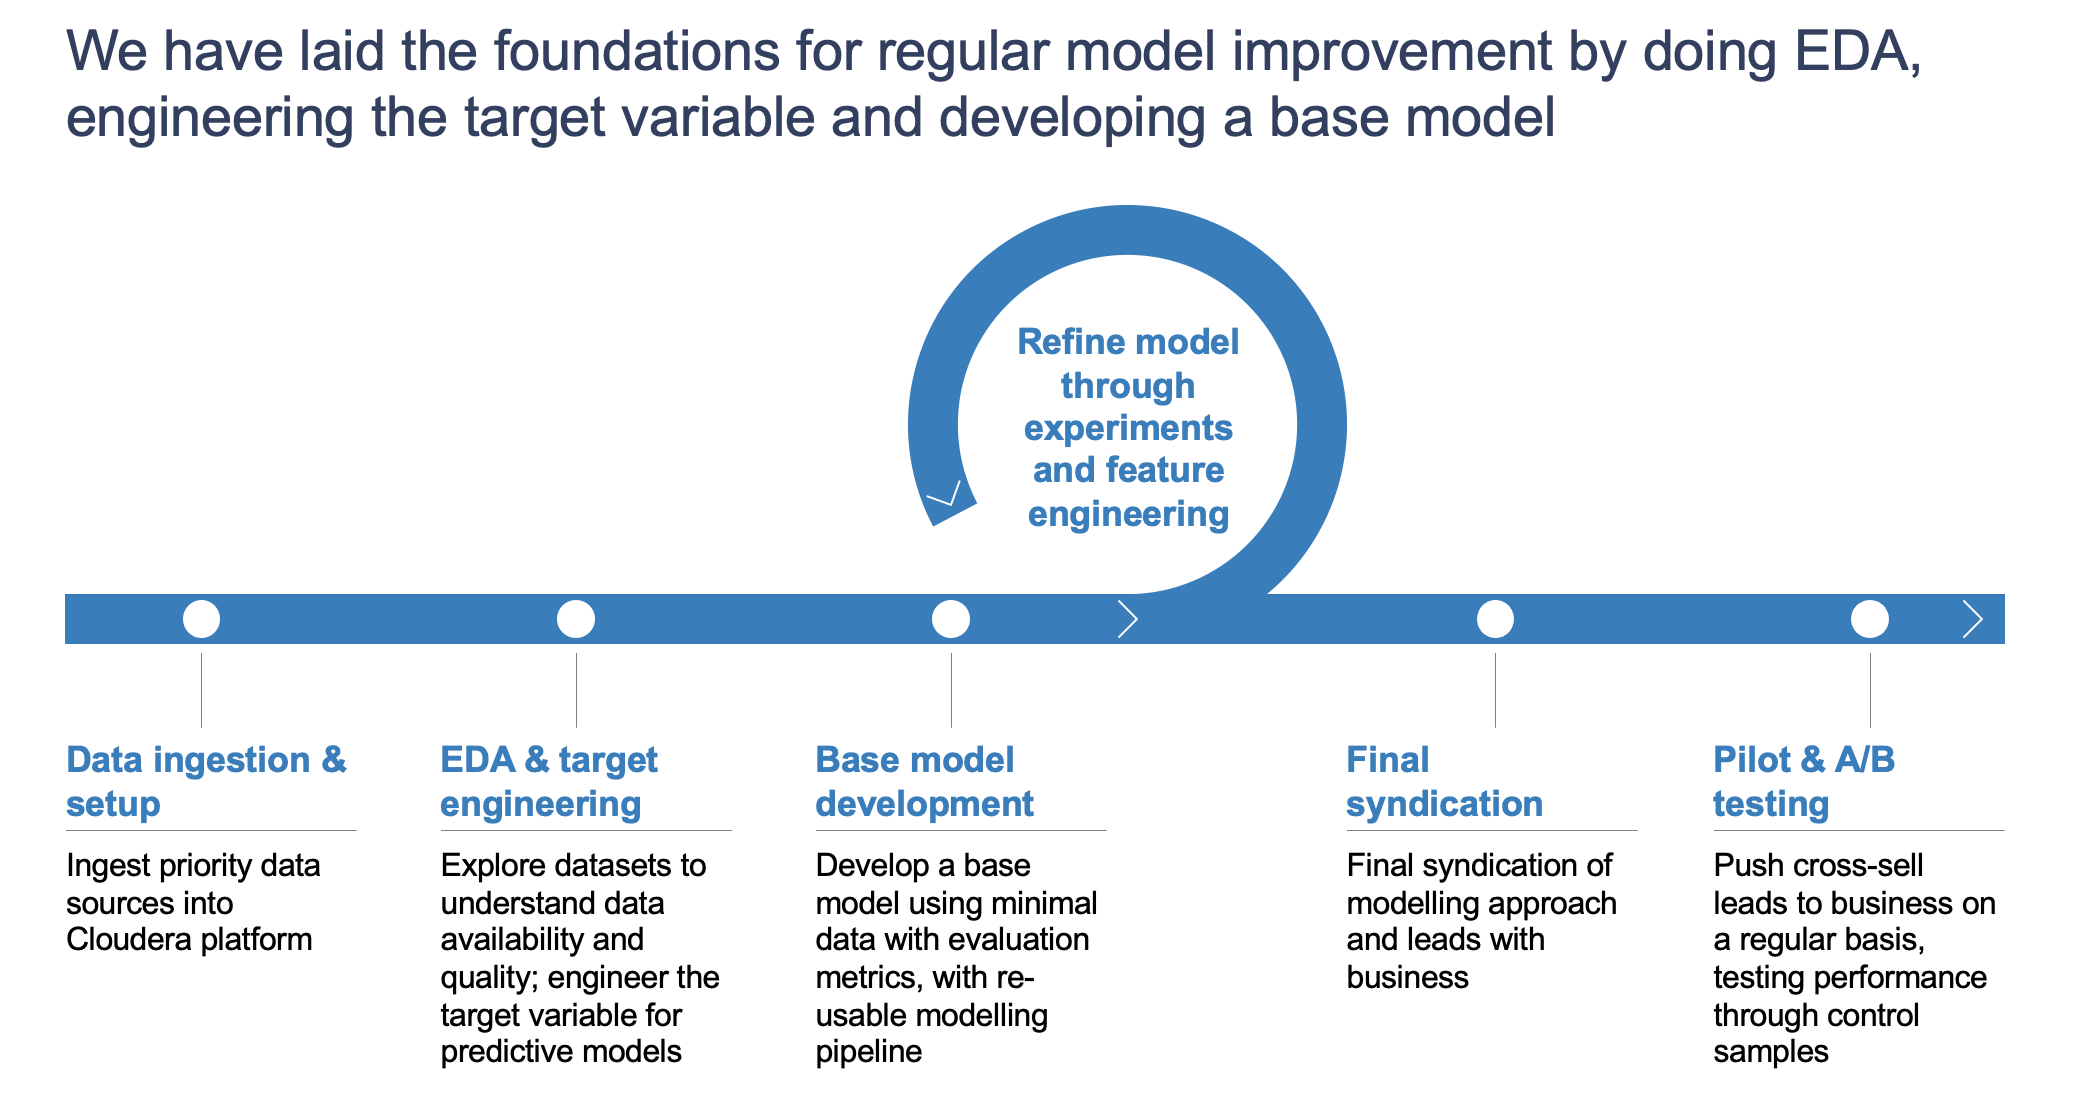

In [138]:
Image(filename='pictures/approach_structure.png')

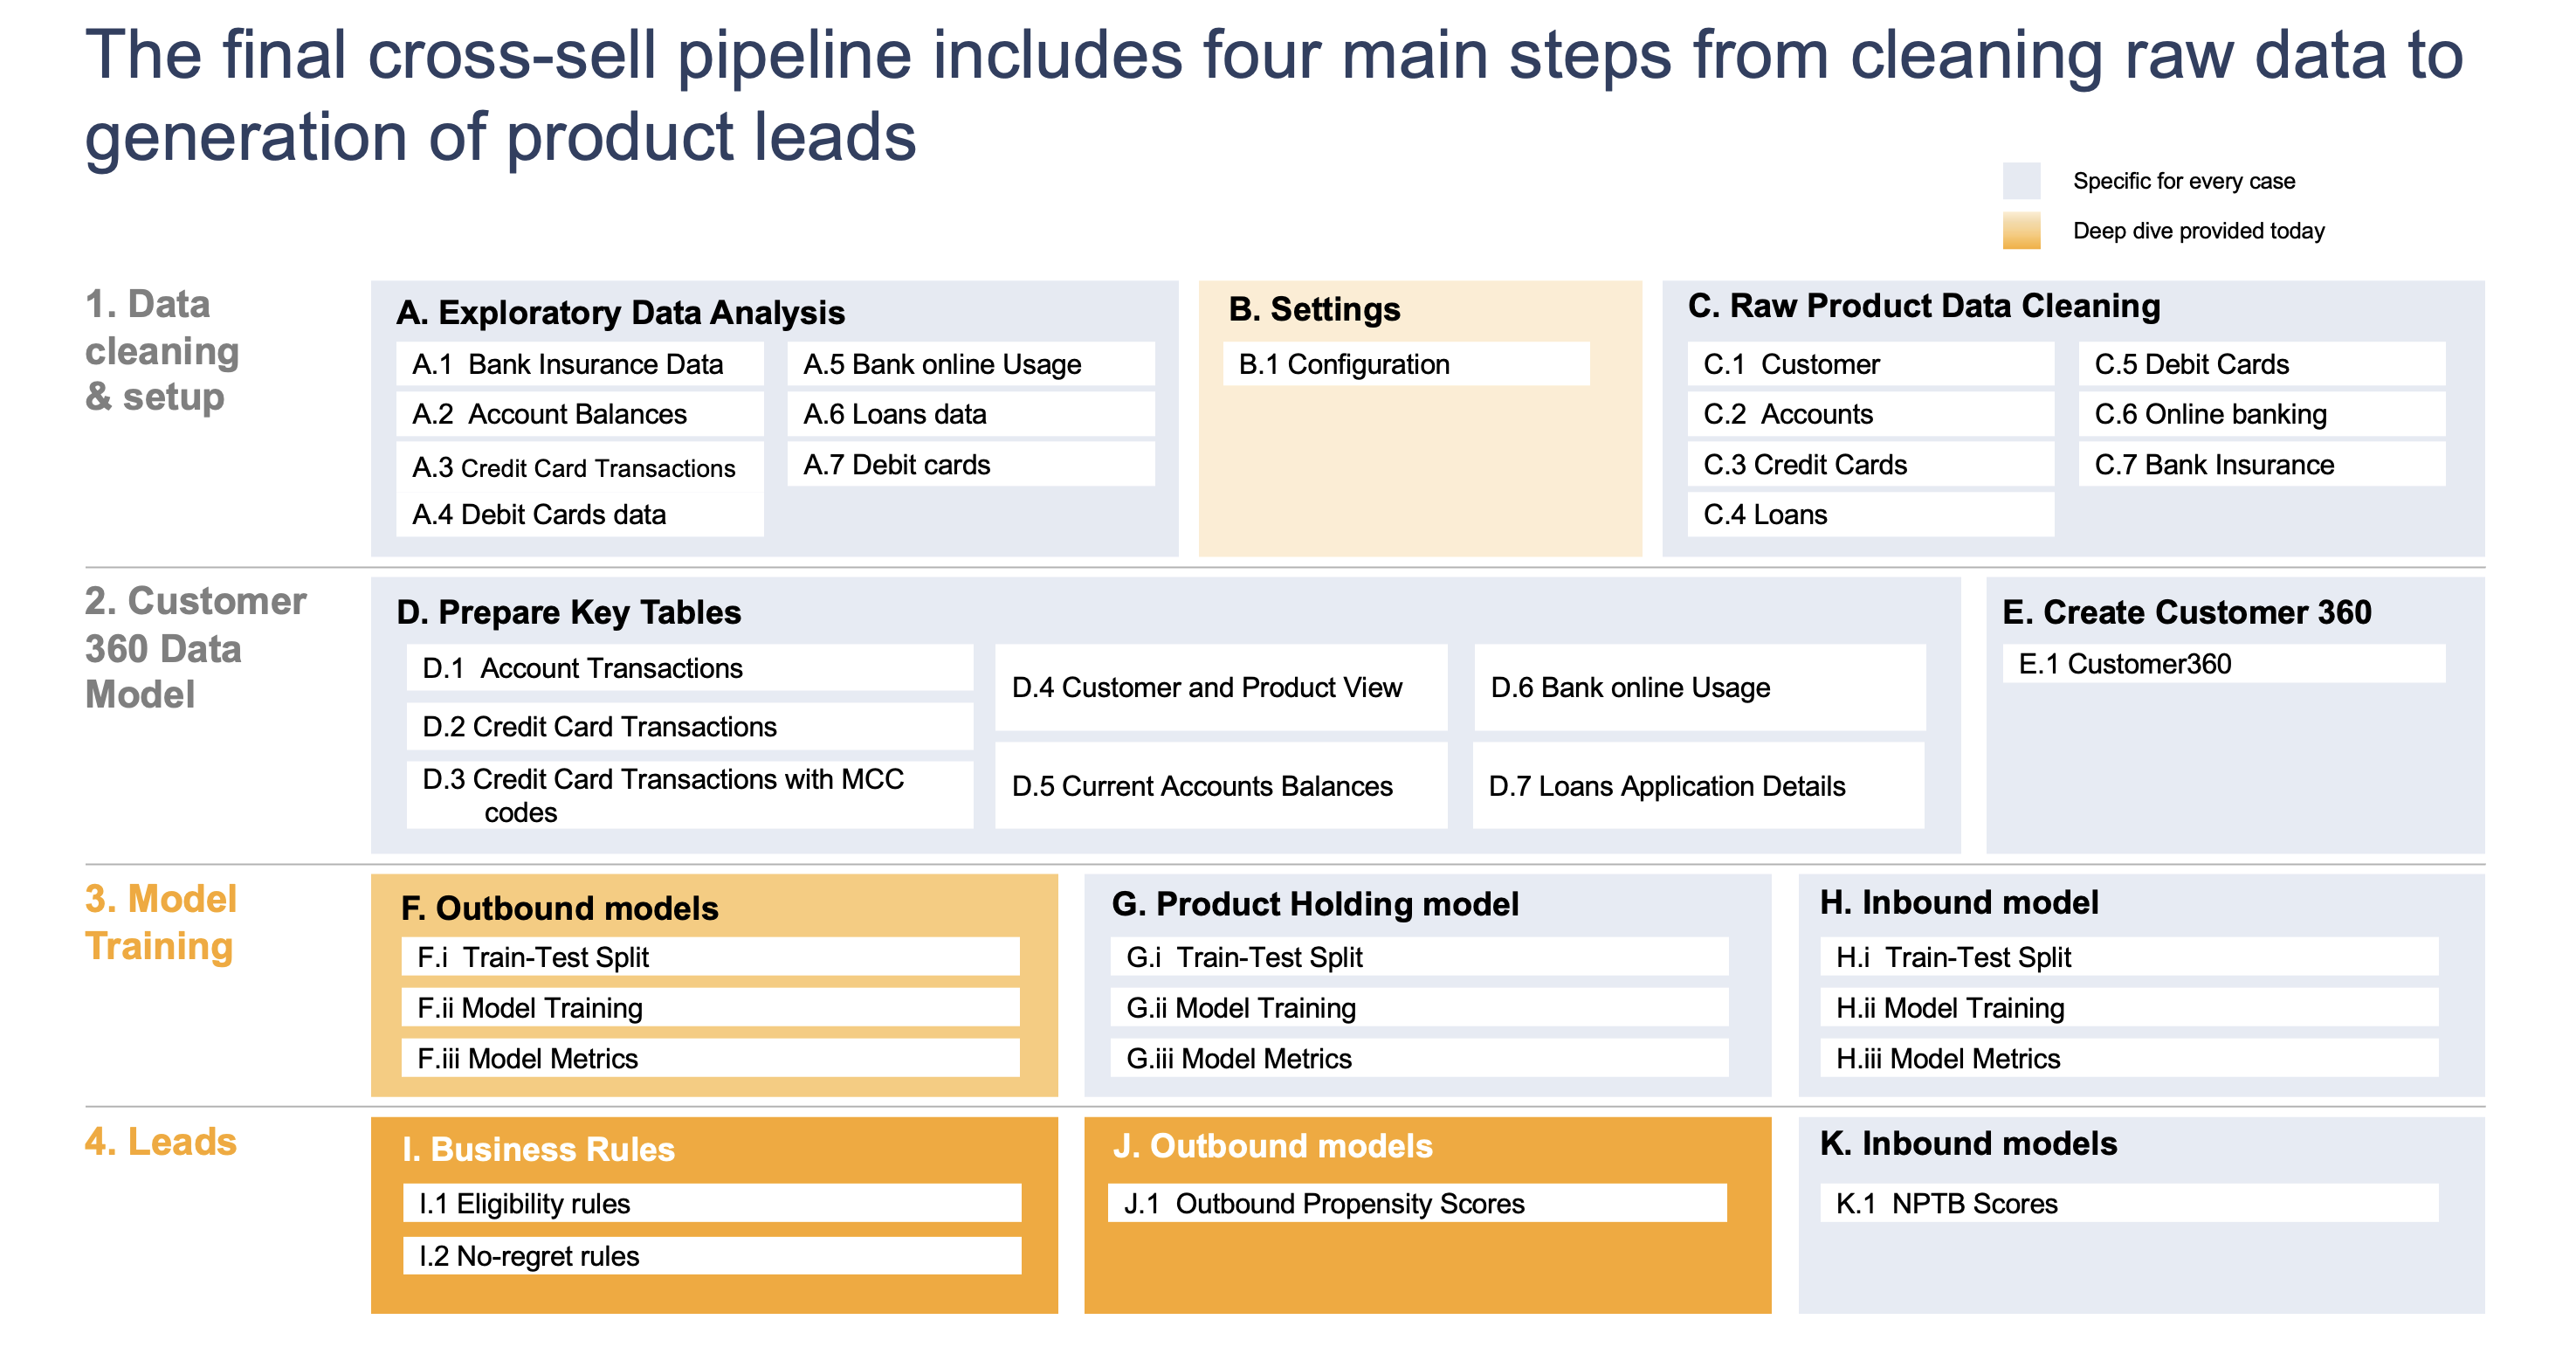

In [139]:
Image(filename='pictures/pipeline.png')

### 2.1 Data cleaning & setup
#### 2.1B Configuration Settings

<style>
    .custom-list {
        list-style-type: disc; /* Use disc bullets */
        color: #686868; /* Set the color for the bullets */
        margin-left: 20px; /* Add left indentation */
    }
    .custom-text {
        color: #686868; /* Set the color for the text */
    }
</style>

<p><span style='color: #686868;'> Let us set date ranges for all further steps of the data preparation process:</p></span></li>
<ul class="custom-list">
    <li><span style='color: #67738C; font-weight: bold;'>model version prefix:</span>  <span style='color: #686868;'>for model versioning</span></li>
    <li><span style='color: #67738C; font-weight: bold;'>time_series_prep_sdate, time_series_prep_edate:</span> <span style='color: #686868;'>customer 360 preparation dates</span></li>
    <li><span style='color: #67738C; font-weight: bold;'>train_start_date, train_end_date:</span> <span style='color: #686868;'>model training periods</span></li>
    <li><span style='color: #67738C; font-weight: bold;'>test_start_date, test_end_date:</span> <span style='color: #686868;'>model testing periods (OOT sample)</span></li>
    <li><span style='color: #67738C; font-weight: bold;'>scoring period (for leads):</span> <span style='color: #686868;'>score_date</span></li>
</ul>

In [78]:
# All output files will be prefixed by this
model_version_prefix = "20230831"

# The customer 360 view will be prepared using this range
time_series_prep_sdate = "2021-04-01"
time_series_prep_edate = "2023-09-01"

# Model trained on this range
train_start_date = "2022-06-01"
train_end_date = "2023-06-01"

# Model tested on this range
test_start_date = "2023-07-01"
test_end_date = "2023-09-01"

# Model scored on this range
score_date = "2023-10-01"

# Save as a spark table so we can read in other places
schema = [
    "time_series_prep_sdate",
    "time_series_prep_edate",
    "train_start_date",
    "train_end_date",
    "test_start_date",
    "test_end_date",
    "score_date",
    "model_version_prefix",
]

values = [(
    time_series_prep_sdate,
    time_series_prep_edate,
    train_start_date,
    train_end_date,
    test_start_date,
    test_end_date,
    score_date,
    model_version_prefix,
)]

config = spark.createDataFrame(data=values, schema=schema)
#config.write.mode('overwrite').saveAsTable("db.xs0_config")
config.show()

config.write.mode('overwrite').parquet("xs0_config.parquet")

#spark.table("db.xs0_config").show()

+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+
|time_series_prep_sdate|time_series_prep_edate|train_start_date|train_end_date|test_start_date|test_end_date|score_date|model_version_prefix|
+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+
|            2021-04-01|            2023-09-01|      2022-06-01|    2023-06-01|     2023-07-01|   2023-09-01|2023-10-01|            20230831|
+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+



### 2.2 Customer 260 Data Model
#### 2.2E Customer 360

<style>
    .custom-list {
        list-style-type: none; /* Remove default bullets */
        padding-left: 0; /* Remove left indentation */
    }

    .custom-list li:before {
        content: "•"; /* Use a custom bullet character, such as a black dot • */
        color: #686868; /* Set the color for the bullet */
        font-weight: bold; /* Set the font weight for the bullet */
        padding-right: 5px; /* Add some space between the bullet and text */
    }
</style>

<span style='color: #67738C; font-weight: bold;'>Customer360 dataset that has been prepared unlocks multiple CVM use cases...:<span>
<ul class="custom-list">
    <li style="color: #686868;">Cross-sell (outbound + inbound) (target - "product + __new_in_period_ind")</li>
    <li style="color: #686868;">Churn prediction (target - "product + __close_in_period")</li>
    <li style="color: #686868;">Trigger rules (target - "product + __time_to_next_maturity")</li>
    <li style="color: #686868;">Up-sell (target - "product + __new_in_period_ind") </li>
</ul>

<span style='color: #67738C; font-weight: bold;'>...using multiple data sources:<span>
<ul class="custom-list">
    <li style="color: #686868;">Customer product holding history:</li>
    <li style="color: #686868;">Credit cards</li>
    <li style="color: #686868;">Debit cards</li>
    <li style="color: #686868;">Accounts</li>
    <li style="color: #686868;">Loans</li>
    <li style="color: #686868;">Bancassurance</li>
    <li style="color: #686868;">Online banking</li>
    <li style="color: #686868;">Account transaction history</li>
    <li style="color: #686868;">Account balance history</li>
    <li style="color: #686868;">Credit card transaction history</li>
    <li style="color: #686868;">Debit card transaction history</li>
    <li style="color: #686868;">Bank online interactions</li>
    <li style="color: #686868;">CRM interactions</li>
    <li style="color: #686868;">Credit history data</li>
</ul>


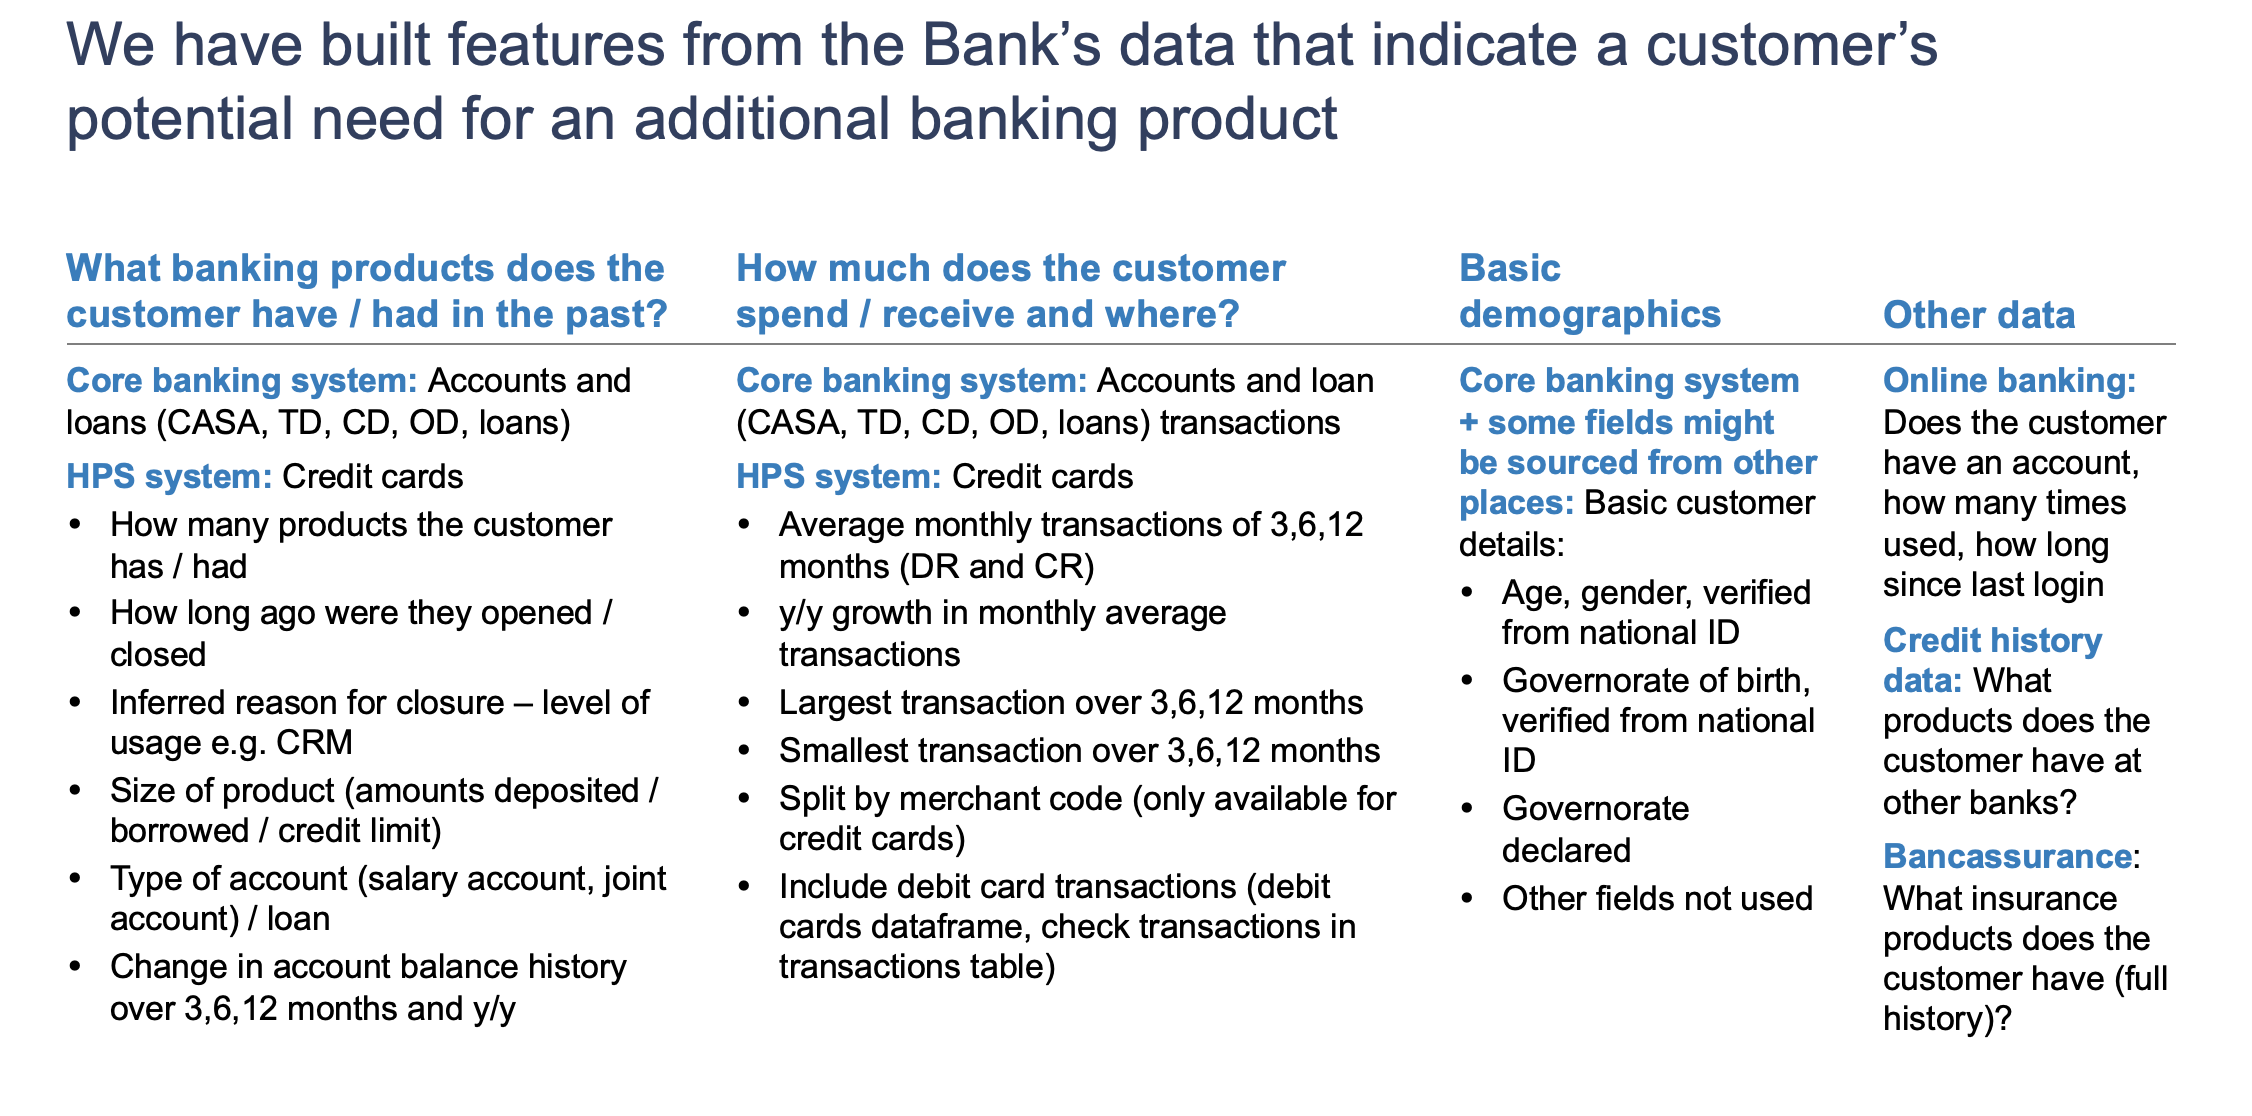

In [140]:
Image(filename='pictures/features_description.png')

> ⚠️ **Please Pay Attention**: In this notebook, only the cross-sell pipeline flow is demonstrated. Due to confidentiality and privacy concerns, we cannot use real client data for demonstration purposes. Hence, the code is demonstrated using synthetic data only. The data presented here are not interpretable and are solely for demonstration and illustrative purposes.

#### 2.1.1 Data: Generate synthetic dataset

<style>
    .custom-list {
        list-style-type: none; /* Remove default bullets */
        padding-left: 0; /* Remove left indentation */
    }

    .custom-list li:before {
        content: "•"; /* Use a custom bullet character, such as a black dot • */
        color: #686868; /* Set the color for the bullet */
        font-weight: bold; /* Set the font weight for the bullet */
        padding-right: 5px; /* Add some space between the bullet and text */
    }
</style>

<span style='color: #67738C;'> As soon as we cannot use the origincal dataset, let's generate synthetic version of Customer 360 for further code testing.<span>
<span style='color: #67738C;'> Please find generation of the sythetic dataset here: 
<span style='color: #67738C; font-weight: bold;'> 0_Customer360_Generation.ipynb <span>
    

In [129]:
# Read the DataFrame
customer360 = spark.read.parquet('data/customer360.parquet')

### 2.3F Outbound models

##### Settings

In [3]:
# ==========================================
# Load config
# ==========================================

#config = spark.table("db.xs0_config")

config = spark.read.parquet('xs0_config.parquet')

time_series_prep_sdate = config.collect()[0][0]
time_series_prep_sdate = config.collect()[0][0]
time_series_prep_edate = config.collect()[0][1]
train_start_date = config.collect()[0][2]
train_end_date = config.collect()[0][3]
test_start_date = config.collect()[0][4]
test_end_date = config.collect()[0][5]
score_date = config.collect()[0][6]
model_version_prefix = config.collect()[0][7]

config.show()

+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+
|time_series_prep_sdate|time_series_prep_edate|train_start_date|train_end_date|test_start_date|test_end_date|score_date|model_version_prefix|
+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+
|            2021-04-01|            2023-09-01|      2022-06-01|    2023-06-01|     2023-07-01|   2023-09-01|2023-10-01|            20230831|
+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+



In [27]:
models = [
    'savacc', 
    'deposits', 
    'bank_online', 
    'credit_cards', 
    'insurance', 
    'debit_cards', 
    'secured_loans', 
    'unsecured_loans'
]

### 2.3.F.i Train Test Split

In [8]:
## Prepare Train Datasets

# 1) Filter to include only requried customers (active and did not have product at SOP) and create the indicator column
# 2) Filter to include only the required periods
# 3) Up sample for train
# 4) Random sample for test

current_date = dt.datetime.now().strftime("yyMMdd")

# 1) Filter to include only requried customers (active and did not have product at SOP) and create the indicator column
df = customer360

df_all_train = df.filter(
        (F.col("__PERIOD") >= F.lit(train_start_date)) &\
        (F.col("__PERIOD") <= F.lit(train_end_date))
    ).cache()

for p in models:
    
    # 3) Up sample for train
    df_train = df_all_train.filter(F.col(p+"__active_SOP") == F.lit(0))
    
    # 4) Save
    df_train.write.mode('overwrite').parquet("data/xs3_1_C360_TSPropensity_train_"+p + "_" +model_version_prefix)

## Prepare Test Datasets


# 1) Filter to include only requried customers (active and did not have product at SOP) and create the indicator column
# 2) Filter to include only the required periods
# 3) Up sample for train
# 4) Random sample for test
import datetime as dt

current_date = dt.datetime.now().strftime("yyMMdd")

# 1) Filter to include only requried customers (active and did not have product at SOP) and create the indicator column
df = customer360.filter(
        (F.col("customer_active_SOP") == F.lit(1)) &\
        (F.col("tenure") >= F.lit(3/12))
    )

df_all_test = df.filter(
        (F.col("__PERIOD") >= F.lit(test_start_date)) &\
        (F.col("__PERIOD") <= F.lit(test_end_date))
    )

for p in models:
    
    # 3) Up sample for train
    df_test = df_all_test.filter(F.col(p+"__active_SOP") == F.lit(0))
    
    # 4) Save
    df_test.write.mode('overwrite').parquet("data/xs3_1_C360_TSPropensity_test_"+p + "_" +model_version_prefix)

23/09/12 19:01:26 WARN CacheManager: Asked to cache already cached data.


23/09/12 19:01:48 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:01:50 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:01:50 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:01:50 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:01:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:01:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:01:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:01:53 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:01:53 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:01:53 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:01:53 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:01:54 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:01:54 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:01:54 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:01:56 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:01:56 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:01:56 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:01:56 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:01:57 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:01:57 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:01:57 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:01:58 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:01:58 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:01:58 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:01:58 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers


23/09/12 19:01:59 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:01:59 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:01:59 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:02:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:02:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:02:00 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:02:01 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:02:01 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:02:01 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:02:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:02:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:02:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:02:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers


23/09/12 19:02:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:02:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:02:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:02:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:02:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:02:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers


23/09/12 19:02:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:02:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:02:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:05 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:02:05 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:02:05 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:02:05 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers


23/09/12 19:02:06 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:02:06 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:02:06 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:08 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:12 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:14 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:16 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:18 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:21 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 19:02:22 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


### 2.3.F.ii Model Training

##### Imports

In [10]:
import sys
import os
import subprocess

# Matplotlib stuff
import matplotlib.pyplot as plt
plt.switch_backend("Agg")
def show_plot(p, width=600, clear=True):
    # p.switch_backend("Agg")
    img = StringIO.StringIO()
    p.savefig(img, format="svg")
    img.seek(0)
    if clear:
        p.clf()

# Everything else
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext ,Row
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, monotonically_increasing_id, current_date, date_format
from pyspark.sql.types import FloatType
from pyspark.sql.types import StructType, StructField, FloatType, StringType
from pyspark.sql import Row

from datetime import date
from dateutil.relativedelta import relativedelta

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd

from pyspark.ml.feature import StringIndexer
import copy
import datetime as dt


##### Settings

In [14]:
# ==========================================
# Settings
# ==========================================

do_grid_search = False
target_variable_suffix = "__new_in_period"

# ==========================================
# Paths
# ==========================================
input_table = spark.read.parquet('data/customer360.parquet')

savacc_path = "models/propensity_savacc_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
deposits_path = "models/propensity_deposits_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
bank_online_path = "models/propensity_bank_online_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
credit_cards_path = "models/propensity_credit_cards_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
insurance_path = "models/propensity_insurance_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
debit_cards_path = "models/propensity_debit_cards_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
secured_loans_path = "models/propensity_secured_loans_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
unsecured_loans_path = "models/propensity_unsecured_loans_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)

In [15]:
# ==========================================
# Train and test sets
# ==========================================

df_train_dict = {p: spark.read.parquet("data/xs3_1_C360_TSPropensity_train_"+p+ "_" +model_version_prefix).fillna(-1) for p in models}

df_test_dict = {p: spark.read.parquet("data/xs3_1_C360_TSPropensity_test_"+p + "_" +model_version_prefix).fillna(-1) for p in models}

In [16]:
# ==========================================
# Outputs
# ==========================================

metrics = pd.DataFrame(index=models, columns=["Gini_Train", "Gini_Test"])

    
final_models = {
    "savacc": None,
    "deposits": None,
    "bank_online": None,
    "credit_cards": None,
    "insurance": None,
    "debit_cards": None,
    "secured_loans": None,
    "unsecured_loans": None,
}

##### Features Preparation

In [ ]:
# ==========================================
# Features
# ==========================================

# Create feature list for each model


xs_df = input_table.limit(1)

# Product holding features
feature_list__active_sop =              [x for x in xs_df.columns if "_active_sop" in x]
feature_list___active_at_or_before_sop= [x for x in xs_df.columns if "_active_at_or_before_sop" in x]
feature_list___time_since_last_new =    [x for x in xs_df.columns if "_time_since_last_new" in x]
feature_list___time_since_last_close =  [x for x in xs_df.columns if "_time_since_last_close" in x]
feature_list___time_since_first_new =   [x for x in xs_df.columns if "_time_since_first_new" in x]
feature_list___age_of_oldest_active =   [x for x in xs_df.columns if "_age_of_oldest_active" in x]
feature_list___deposit_balances =  [x for x in xs_df.columns if "_fct" in x]
feature_list___time_to_next_maturity =  [x for x in xs_df.columns if "_time_to_next_maturity" in x]
feature_list___static =  [x for x in xs_df.columns if "static" in x]
feature_list___bmo_usage =  [x for x in xs_df.columns if "bmo_usage_" in x]
feature_list___income = ['Monthly_Income', 'LOAN_AMT', 'Net_Prft', 'Monthly_Income', 'ReveNue']

# Card trxs and account balance features
feature_list___transaction =            [x for x in xs_df.columns if "tfeat" in x]
feature_list___transactions_total =     [x for x in xs_df.columns if "trn_trn" in x]

# Numericals
feature_list_num = ["age", "employed"]#, "tenure"]

# Cat cols
cat_cols_list = [
    "id_gender",
    "customer_category_cleaned",
    "marital_status_cleaned",
    "customer_governorate",
]

# Full list
feature_list = feature_list__active_sop + feature_list___active_at_or_before_sop + feature_list___time_since_last_new + feature_list___time_since_last_close + feature_list___time_since_first_new + feature_list___age_of_oldest_active + feature_list___time_to_next_maturity + feature_list___transaction + feature_list_num + [c+"_enc" for c in cat_cols_list] + feature_list___deposit_balances + feature_list___time_to_next_maturity + feature_list___static + feature_list___transactions_total + feature_list___bmo_usage + feature_list___income 


feature_list = list(set(feature_list))
feature_list = sorted(feature_list)

for x in feature_list:
    print(x)

# Specify features to drop for each model
features_to_drop = {
    "savacc": [],
    "deposits": [],
    "bank_online": [],
    "credit_cards": [],
    "insurance": [],
    "debit_cards": [],
    "secured_loans": [],
    "unsecured_loans": [],
}

# Remove selected features from feature list for each model
feature_names = {}

for p in models:
    feature_names[p] = feature_list
    
    for feature in features_to_drop[p]:
        feature_names[p].remove(feature)

##### Model Training

In [18]:
# Training loop without grid search

### Training dataset only

secondelement=udf(lambda v:float(v[1]), FloatType())

if do_grid_search == False:
    for p in models:
    
        # Reading datasets from hive
        product_df_train = df_train_dict[p]
        #product_df_test = df_test_dict[p]
        current_date = dt.datetime.now().strftime("%Y%m%d")
                    
        # Create vector assembler for features
        stringIndexers = [StringIndexer(inputCol=c, outputCol=c+"_enc", handleInvalid = "keep") for c in cat_cols_list]
        vectorAssembler = VectorAssembler(inputCols = feature_names[p], outputCol = "features", handleInvalid = "skip")
        #gbt = GBTClassifier(featuresCol = "features", labelCol =p + "___new_in_period_ind", maxDepth = 5, maxBins = 32, minInstancesPerNode = 1, minInfoGain = 0.0, subsamplingRate=0.8)
        #gbt = GBTClassifier(featuresCol = "features", labelCol =p + "___new_in_period_ind", maxDepth = 5, maxBins = 64, minInstancesPerNode = 10, minInfoGain = 0.0, subsamplingRate=0.8) #ba 3
        gbt = GBTClassifier(featuresCol = "features", labelCol =p + target_variable_suffix, maxDepth = 5, maxBins = 364, minInstancesPerNode = 1, minInfoGain = 0.0, subsamplingRate=0.8)
        pipeline = Pipeline(stages = stringIndexers + [vectorAssembler, gbt])
                
        # # Fit model
        model = pipeline.fit(product_df_train)
        preds_train = model.transform(product_df_train)
                    
        # Evaluation
        evaluator =  BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = p+target_variable_suffix)
        metrics.loc[p, "Gini_Train"] = evaluator.evaluate(preds_train,  {evaluator.metricName: "areaUnderROC"}) * 2 - 1
                
        # Get and save feature importances(!overwrite)
        tree = model.stages[-1]
        importances = tree.featureImportances.toArray()
        importances = [float(x) for x in importances]
        sorted_importances = sorted(zip(importances, feature_names[p]), reverse=True)
        sorted_importances, sorted_names = zip(*sorted_importances)
        zipped_data = dict(zip(sorted_importances, sorted_names))

        # Convert zipped_data to a DataFrame using SparkSession
        import pyspark.sql.functions as F

        df3 = spark.createDataFrame(
            [(item[0], item[1]) for item in zipped_data.items()],
            ["importance", "feature"]
        )

        # Write the DataFrame to Parquet
        df3.write.mode('overwrite').parquet("data/xs3_2_PropensityModelSpark_feature_importances_" + p + "_" + model_version_prefix)

        # Store the model
        final_models[p] = copy.copy(model)
        print(p)
                    

23/09/12 19:44:23 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:44:23 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:44:23 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:44:23 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:44:23 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:44:23 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:44:23 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:44:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:44:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:44:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:44:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:44:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:44:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:44:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:45:16 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:45:16 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:45:16 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:45:16 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:45:16 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:45:16 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:45:16 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:45:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:45:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:45:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:45:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:45:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:45:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:45:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:46:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:46:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:46:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:46:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:46:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:46:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:46:10 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:46:36 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:46:36 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:46:36 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:46:36 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:46:36 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:46:36 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:46:36 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:47:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:47:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:47:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:47:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:47:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:47:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:47:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 19:47:31 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 19:47:31 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:47:31 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:47:31 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 19:47:31 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 19:47:31 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 19:47:31 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

In [19]:
# Save models

final_models['savacc'].write().overwrite().save(savacc_path)
final_models['deposits'].write().overwrite().save(deposits_path)
final_models['bank_online'].write().overwrite().save(bank_online_path)
final_models['credit_cards'].write().overwrite().save(credit_cards_path)
final_models['insurance'].write().overwrite().save(insurance_path)
final_models['debit_cards'].write().overwrite().save(debit_cards_path)
final_models['secured_loans'].write().overwrite().save(secured_loans_path)
final_models['unsecured_loans'].write().overwrite().save(unsecured_loans_path)

In [72]:
# Evaluate on test set

secondelement=udf(lambda v:float(v[1]), FloatType())

for p in models:
    model = final_models[p]
    # Reading datasets from hive
    product_df_test = df_test_dict[p].cache()
    current_date = F.date_format(F.current_date(), 'yyyyMMdd')
    
    # # Fit model
    preds_test = model.transform(product_df_test)
            
    # Evaluation
    evaluator =  BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = p+target_variable_suffix)
    metrics.loc[p, "Gini_Test"] = evaluator.evaluate(preds_test,  {evaluator.metricName: "areaUnderROC"}) * 2 - 1
        
    # #save the result (ids, predictions, probabilities)
    df_predictions_test = preds_test.select("customer_no", p+target_variable_suffix, "prediction", "rawPrediction", secondelement(preds_test["probability"]), "customer_no", "local_branch",  "customer_category_cleaned", "age", '__PERIOD').withColumnRenamed("<lambda>(probability)", p+"__probability")
            # final.write.mode('overwrite').saveAsTable(p+'_prob_loop')
            
    # #extracting tes dataset and saving it localluy for further reading in python environment and creating shap graph
    df_targ_preds_test = product_df_test.join(df_predictions_test.select("customer_no", "prediction", p+"__probability", '__PERIOD', "rawPrediction"),["customer_no", "__PERIOD"]).cache()
    df_targ_preds_test.write.mode('overwrite').parquet('data/xs3_2_TargetPreds_TestDataset_2_' + p + "_" + model_version_prefix)

23/09/12 22:58:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/09/12 22:58:36 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 22:58:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 22:58:54 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 22:58:58 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 22:59:04 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/09/12 22:59:14 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


### 2.3.F.iii Model Metrics

##### Imports

In [75]:
%matplotlib inline

import sys
import os
import subprocess

# Matplotlib stuff
import matplotlib.pyplot as plt
#plt.switch_backend("Agg")
import io

def show_plot(p, width=600, clear=True):
    img = io.StringIO()
    p.savefig(img, format="svg")
    img.seek(0)
    if clear:
        p.clf()
        
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext ,Row
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, monotonically_increasing_id, current_date, date_format
from pyspark.sql.types import FloatType
from pyspark.sql.types import StructType, StructField, FloatType, StringType
from pyspark.sql import Row

from datetime import date
from dateutil.relativedelta import relativedelta


from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd

from pyspark.ml.feature import StringIndexer
import copy
import datetime as dt

from pyspark.ml.feature import Bucketizer

import datetime as dt
from pyspark.ml.feature import QuantileDiscretizer
import numpy as np

##### Settings

In [33]:
target_variable_suffix = "__new_in_period"

# ==========================================
# Paths
# ==========================================

savacc_path = "models/propensity_savacc_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
deposits_path = "models/propensity_deposits_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
bank_online_path = "models/propensity_bank_online_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
credit_cards_path = "models/propensity_credit_cards_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
insurance_path = "models/propensity_insurance_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
debit_cards_path = "models/propensity_debit_cards_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
secured_loans_path = "models/propensity_secured_loans_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
unsecured_loans_path = "models/propensity_unsecured_loans_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)


final_models = {
    "savacc": PipelineModel.load(savacc_path),
    "deposits":  PipelineModel.load(deposits_path),
    "bank_online":  PipelineModel.load(bank_online_path),
    "credit_cards":  PipelineModel.load(credit_cards_path),
    "insurance":  PipelineModel.load(insurance_path),
    "debit_cards":  PipelineModel.load(debit_cards_path),
    "secured_loans":  PipelineModel.load(secured_loans_path),
    "unsecured_loans":  PipelineModel.load(unsecured_loans_path)
}

In [34]:
# ==========================================
# Train and test sets
# ==========================================

df_train_dict = {p: spark.read.parquet("data/xs3_1_C360_TSPropensity_train_"+p+ "_" +model_version_prefix).fillna(-1) for p in models}

df_test_dict = {p: spark.read.parquet("data/xs3_1_C360_TSPropensity_test_"+p + "_" +model_version_prefix).fillna(-1) for p in models}

##### Model Metrics

In [38]:
# ==========================================
# Outputs
# ==========================================
metrics = pd.DataFrame(index=models, columns=["Gini_Train", "Gini_Test"])

In [40]:
# Gini

secondelement=udf(lambda v:float(v[1]), FloatType())

for p in models:

    model = final_models[p]

    product_df_train = df_train_dict[p]

    preds_train = model.transform(product_df_train)
    
    product_df_test = df_test_dict[p]
    
    preds_test = model.transform(product_df_test.drop("prediction","rawPrediction"))
    
    # Evaluation
    evaluator =  BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = p+target_variable_suffix)
    metrics.loc[p, "Gini_Train"] = evaluator.evaluate(preds_train,  {evaluator.metricName: "areaUnderROC"}) * 2 - 1
    metrics.loc[p, "Gini_Test"] = evaluator.evaluate(preds_test,  {evaluator.metricName: "areaUnderROC"}) * 2 - 1

# Convert metrics to a pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the pandas DataFrame
metrics_df

,Gini_Train,Gini_Test
savacc,0.52099,-0.026644
deposits,0.532064,0.012083
bank_online,0.50885,-0.004923
credit_cards,0.495138,-0.026929
insurance,0.486356,-0.000526
debit_cards,0.494257,0.00561
secured_loans,0.513818,0.009301
unsecured_loans,0.524427,0.023995


##### Plots

###### Feature Importance

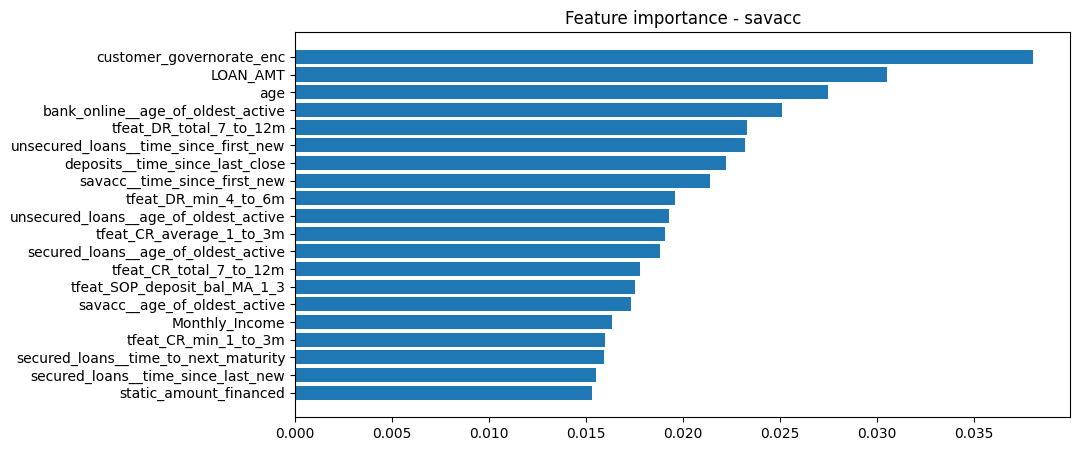

In [71]:
# Feature Importance

plt.figure(figsize=(10, 5))

models_to_show = ['savacc']

for p in models_to_show:
    importances = spark.read.parquet("data/xs3_2_PropensityModelSpark_feature_importances_" + p + "_" + model_version_prefix).toPandas()
    importances = importances.sort_values("importance", ascending=False)
    if len(importances) < 20:
        n = len(importances)
    else:
        n = 20
    plt.barh(importances["feature"][0:n].loc[::-1].values, importances["importance"][0:n].loc[::-1].values)
    plt.title("Feature importance - " + p)
    plt.show()

###### Lift Plot

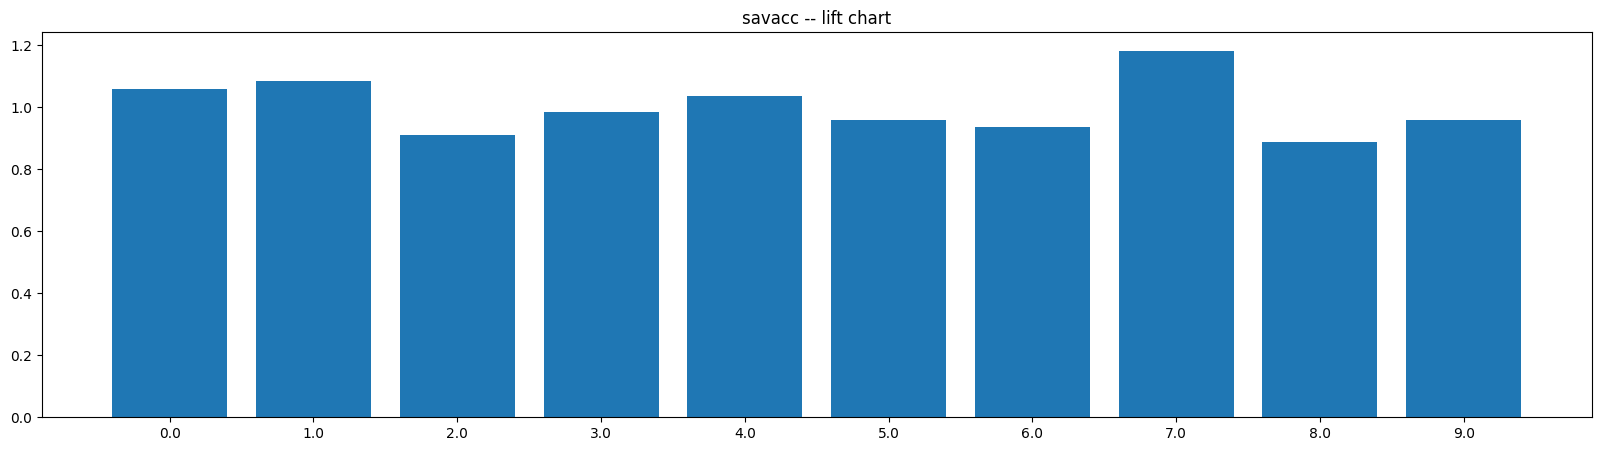

In [89]:
# Lift

for p in models_to_show:
    # Get test predictions
    # preds_test = model.transform(product_df_test)
    # preds_test = preds_test.select("customer_no", p+"___new_in_period_ind", "prediction", secondelement(preds_test["probability"])).withColumnRenamed("<lambda>(probability)", p+"_prob").toPandas()

    # groups, mean, top_decile_lift = single_lift_chart(preds_test, p+"___new_in_period_ind", p+"_prob")
    # lift_charts[p] = [groups, mean, top_decile_lift]
    # del(preds_test)
    
    # Reading datasets from hive
    product_df_train = df_train_dict[p]
    #product_df_test = df_test_dict[p].sample(0.1)
    
    # Get test predictions
    #preds_test = model.transform(product_df_test)
    #preds_test = spark.table("analyatics_zone.TSPropensity_score_for_"+p + "_2023062111").select("customer_no", p+"___new_in_period_ind", "prediction",  p+"__probability")
    preds_test = spark.read.parquet("data/xs3_2_TargetPreds_TestDataset_2_" + p + "_" + model_version_prefix).select("customer_no", p+"__new_in_period", "prediction",  p+"__probability")
    
    mean = preds_test.select(F.avg(p+"__new_in_period")).collect()[0][0]
    
    discretizer = QuantileDiscretizer(inputCol=p+"__probability", outputCol="buckets",numBuckets=10, relativeError=0.00001)
    lift = discretizer.fit(preds_test).transform(preds_test).groupBy("buckets").agg(F.avg(p+"__new_in_period").alias(p+"_conversion")).orderBy("buckets",ascending=True)
    
    lift = lift.withColumn("mean", F.lit(mean))
    lift = lift.withColumn("lift", F.col(p+"_conversion") / F.col("mean"))
    lift = lift.toPandas().sort_values("buckets", ascending=True)
    
    # Create and show the lift chart
    plt.figure(figsize=(20, 5))
    plt.bar(lift["buckets"].astype("str").values, lift["lift"].values)
    plt.title(p+" -- lift chart")
    plt.show()  # Display the plot

###### Confusion Matrix

In [93]:
# Confusion Matrix

import datetime as dt
confusion_matrices_df = None
secondelement=udf(lambda v:float(v[1]), FloatType())

for p in models_to_show:
    
    target = p+"__new_in_period"
    # Get test predictions
    preds_test = spark.read.parquet('data/xs3_2_TargetPreds_TestDataset_2_' + p + "_" + model_version_prefix).select("customer_no", p+"__new_in_period", "prediction",  p+"__probability")
    #preds_test = preds_test.select("customer_no", p+"___new_in_period_ind", "prediction", secondelement(preds_test["probability"])).withColumnRenamed("<lambda>(probability)", p+"_prob")
    #preds_test = spark.table('analyatics_zone.3_2_TargetPreds_TestDataset_' + p +  "_2023062111").select("customer_no", p+"___new_in_period_ind", "prediction",  p+"__probability")
    threshold = preds_test.approxQuantile(p+"__probability", [0.9], 0)[0]
    preds_test = preds_test.withColumn("prediction", F.when(F.col(p+"__probability") >= F.lit(threshold), F.lit(1)).otherwise(F.lit(0)))
    
    preds_test = preds_test.withColumn("type",
        F.when((F.col("prediction") == F.lit(1)) & (F.col(target) == F.lit(1)), F.lit("TP"))\
         .when((F.col("prediction") == F.lit(1)) & (F.col(target) == F.lit(0)), F.lit("FP"))\
         .when((F.col("prediction") == F.lit(0)) & (F.col(target) == F.lit(0)), F.lit("TN"))\
         .when((F.col("prediction") == F.lit(0)) & (F.col(target) == F.lit(1)), F.lit("FN"))\
         .otherwise(F.lit(None))
    )
    
    matrix = preds_test.groupBy("type").agg(F.count("customer_no").alias("count")).withColumn("model", F.lit(p))
    
    if confusion_matrices_df is None:
        confusion_matrices_df = matrix
    else:
        confusion_matrices_df = confusion_matrices_df.union(matrix)
        
confusion_matrices_df.write.mode('overwrite').parquet("data/xs3_3_PropensityModelSpark_confusion_matrices_"+model_version_prefix)

for p in models_to_show:
    print("")
    print("")
    print("="*100)
    print(p)
    print("")
    print("")
    data = spark.read.parquet("data/xs3_3_PropensityModelSpark_confusion_matrices_"+model_version_prefix).filter(F.col("model") == F.lit(p)).toPandas()
    
    # Create a DataFrame in the matrix format
    matrix = pd.DataFrame(index=['Actual Positive', 'Actual Negative'],
                          columns=['Predicted Positive', 'Predicted Negative'])
    
    # Fill the DataFrame with your data
    tp = float(data.loc[data['type'] == 'TP', 'count'].values[0])
    tn = float(data.loc[data['type'] == 'TN', 'count'].values[0])
    fn = float(data.loc[data['type'] == 'FN', 'count'].values[0])
    fp = float(data.loc[data['type'] == 'FP', 'count'].values[0])
    
    matrix.loc['Actual Positive', 'Predicted Positive'] = data.loc[data['type'] == 'TP', 'count'].values[0]
    matrix.loc['Actual Negative', 'Predicted Negative'] = data.loc[data['type'] == 'TN', 'count'].values[0]
    matrix.loc['Actual Positive', 'Predicted Negative'] = data.loc[data['type'] == 'FN', 'count'].values[0]
    matrix.loc['Actual Negative', 'Predicted Positive'] = data.loc[data['type'] == 'FP', 'count'].values[0]
    
    # Calculate total sum to convert counts into percentages
    total = matrix.values.sum()
    
    # Convert counts to percentages
    matrix_percent = matrix / total * 100

    # Display the confusion matrix
    print(matrix)
    print("")
    print(matrix_percent)
    print("")
    print("Recall = {r}".format(r=tp/(tp+fn)))



savacc


                Predicted Positive Predicted Negative
Actual Positive                 39                367
Actual Negative               1450              13030

                Predicted Positive Predicted Negative
Actual Positive           0.261991           2.465404
Actual Negative           9.740696          87.531909

Recall = 0.0960591133004926


> 📌 **Note on Client Ranking**: When ranking clients for cross-sell opportunities, it is advisable to use the following formula for more precise and valuable rankings:
>
> **MODEL PROPENSITY x PROFIT/REVENUE** (or any other relevant value of KPI)

### 2.4. Leads: Business Rules + Outbound leads

##### Imports

In [94]:
# ========================
# Imports and setup
# ========================

import sys
import os
import subprocess
from pyspark.sql.functions import udf, monotonically_increasing_id, current_date, date_format
from pyspark.sql.types import StructType, StructField, FloatType, StringType
import datetime as dt

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext, Row

import pyspark.sql.functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import regexp_replace,col,when
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext

from pyspark.ml import PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
pd.set_option("display.max_columns",9999)
pd.set_option("display.max_rows",9999)
pd.set_option("display.width",9999)

import datetime as dt
from pyspark.sql.functions import col, lit
from pyspark.sql import DataFrame


##### Applying Eligibility rules

In [123]:
# Define eligibility rules for each product
eligibility_rules = {
    'secured_loans': ((col('age').between(21, 59)) & (col('deposits__active_SOP') == lit(1))),
    'unsecured_loans': (col('age').between(21, 59)),
    'credit_cards': (col('age').between(21, 59)),
    'bank_insurance': (col('age').between(21, 59)),
    'bmo': (col('age').between(21, 59)),
    'savacc': (col('age').between(21, 59))
}

xs_df = spark.read.parquet('data/customer360.parquet')

for p in models:
    # Apply filters
    df_product: DataFrame = xs_df.filter(
        col(p + "__active_SOP") == lit(0)
    )   

    # Apply eligibility rules
    if p in eligibility_rules:
        eligibility_rule = eligibility_rules[p]
        df_product = df_product.filter(eligibility_rule)
    else:
        print(f"No eligibility rule defined for {p}")
        df_product = df_product

    # Predict
    preds_score = final_models[p].transform(df_product.fillna(-1))
    preds_score = preds_score.select(
        "customer_no",
        "local_branch",
        "customer_category_cleaned",
        "age",
        "customer_governorate",
        col("probability").alias(p + "__probability")
    )
    
    
    # Add Customer Info
    product_leads = preds_score.withColumn("product", lit(p))
    product_leads = product_leads.withColumn("SOURCE_system", lit("CORE_BANKING"))
    product_leads = product_leads.withColumn("date_score", lit(dt.datetime.now().strftime("%Y%m%d")))
    product_leads = product_leads.withColumn("model_version", lit(model_version_prefix))

    # Save the leads as a table
    product_leads.write.mode('overwrite').parquet("data/xs5_1_PropensityLeads_" + p + "_" + model_version_prefix)
    
    print("Done processing for:", p)

23/09/12 23:36:48 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 23:36:48 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:36:48 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:36:48 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 23:36:54 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:36:54 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:36:54 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

Done processing for: savacc
No eligibility rule defined for deposits


23/09/12 23:36:57 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 23:36:57 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:36:57 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:36:57 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 23:37:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:02 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

No eligibility rule defined for bank_online


23/09/12 23:37:05 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 23:37:05 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:05 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:05 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 23:37:11 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:11 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:11 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

23/09/12 23:37:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 23:37:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers


23/09/12 23:37:18 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:18 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:18 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
Done processing for: credit_cards


No eligibility rule defined for insurance


23/09/12 23:37:21 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 23:37:21 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:21 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:21 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 23:37:26 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:26 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:27 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

Done processing for: insurance
No eligibility rule defined for debit_cards


23/09/12 23:37:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 23:37:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:30 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 23:37:35 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:35 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:35 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

Done processing for: debit_cards
23/09/12 23:37:38 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 23:37:38 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:38 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:38 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers


23/09/12 23:37:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:43 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


Done processing for: secured_loans


23/09/12 23:37:46 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/09/12 23:37:46 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:46 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:46 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 67.58% for 10 writers
23/09/12 23:37:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 75.08% for 9 writers
23/09/12 23:37:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/09/12 23:37:51 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,01

##### Generate pilot groups for A/B testing

In [124]:
# Iterate through the models
for p in models:
    # Define the parquet file path
    parquet_path = "data/xs5_1_PropensityLeads_" + p + "_" + model_version_prefix

    # Read the parquet file
    df = spark.read.parquet(parquet_path)

    # Generate a random sample
    df_random = df.filter((col("age") >= 21) & (col("age") <= 59)).limit(100)

    # Generate an ordered sample by propensity
    df_ordered = df.filter((col("age") >= 21) & (col("age") <= 59)).orderBy(col(f"{p}__probability").desc()).limit(100)

    # Add sample_type and date_score columns
    df_random = df_random.withColumn("sample_type", lit("RANDOM")).withColumn("date_score", lit(dt.datetime.now().strftime("%Y-%m-%d")))
    df_ordered = df_ordered.withColumn("sample_type", lit("ORDERED")).withColumn("date_score", lit(dt.datetime.now().strftime("%Y-%m-%d")))

    # Combine random and ordered samples
    df_new = df_random.union(df_ordered)

    # Write the result to a new parquet file
    df_new.write.mode("overwrite").parquet(f"data/xs5_1_PropensityLeads_ABTest_{p}_{model_version_prefix}")

    print("Done processing for:", p)

Done processing for: savacc


Done processing for: deposits


Done processing for: bank_online


Done processing for: credit_cards


Done processing for: insurance


Done processing for: debit_cards
Done processing for: secured_loans


Done processing for: unsecured_loans


##### Checks

In [125]:
savacc = spark.read.parquet(f"data/xs5_1_PropensityLeads_ABTest_savacc_{model_version_prefix}")

In [128]:
savacc.show(5, truncate=False, vertical = True)

-RECORD 0--------------------------------------------------------------
 customer_no               | 16310                                     
 local_branch              | 47                                        
 customer_category_cleaned | 3                                         
 age                       | 27                                        
 customer_governorate      | 7                                         
 savacc__probability       | [0.9518073084442398,0.048192691555760225] 
 product                   | savacc                                    
 SOURCE_system             | CORE_BANKING                              
 date_score                | 2023-09-12                                
 model_version             | 20230831                                  
 sample_type               | ORDERED                                   
-RECORD 1--------------------------------------------------------------
 customer_no               | 26319                              